1. We test several fature/time embeddings
2. MLP vs KAN for the vector field

In [1]:
import torch
import numpy as np
from dataclasses import dataclass, field
from typing import List, Tuple
import matplotlib.pyplot as plt

@dataclass
class Configs:
    
    #...general params:
    workdir : str = '../../results/gauss_test/'   
    device : str = 'cuda:0'
    multi_gpu : bool = False

    #...data params:
    target : str = 'Ngaussians'
    source : str = 'StdGauss'
    num_points : int = 8000
    dim_continuous : int = 2
    dim_discrete : int = 0
    dim_context : int = 0
    num_gaussians : int = 8
    vocab_size : int = 8

    #...model params:
    model : str = 'mlp'
    num_layers : int = 4
    dim_hidden : int = 128 
    dim_continuous_emb : int = 16
    dim_time_emb : int = 16
    time_embedding  : str = 'kan'     
    dropout : float = 0.1
    activation : str = 'GELU'

    #...training params:
    batch_size : int = 128
    data_split_frac : List[float] = field(default_factory = lambda : [0.8, 0.2, 0.0])  # train / val / test 
    epochs: int = 20
    early_stopping : int = None
    min_epochs : int = None 
    print_epochs : int = None   
    num_workers : int = 0
    pin_memory: bool = False

    #...cfm params:
    dynamics : str = 'CFM'
    sigma: float = 0.001

    #...optimization & scheduler params:
    optimizer: str = 'Adam'
    lr : float = 2e-4
    weight_decay : float = 0.0
    optimizer_betas : List[float] = field(default_factory = lambda : [0.9, 0.999])
    optimizer_eps : float = 1e-8
    optimizer_amsgrad : bool = False
    gradient_clip : float = None
    scheduler: str = None
    scheduler_t_max: int = None
    scheduler_eta_min: float = None
    scheduler_gamma: float = None
    scheduler_step_size: int = None

    #...generation pipeline params:
    sampler : str = 'EulerSolver'
    solver = 'euler'
    num_timesteps : int = 100
    time_eps : float = 1e-3

    def __post_init__(self):

        self.data = self.source + '_to_' + self.target
        self.num_colors = 1
        if self.dim_discrete: 
            assert self.dim_discrete == 1
            self.dim_context = 0
            self.dim_context_emb = 0 
            self.num_colors = self.vocab_size
        if self.dim_context:  
            assert self.dim_context == 1
            self.dim_discrete = 0
            self.dim_discretet_emb = 0 
            self.num_colors = self.vocab_size

        if self.multi_gpu: self.device = 'cuda:0'


def plot_trajectories(config, traj, labels, N=100000):
    """Plot trajectories of some selected samples."""
    plt.figure(figsize=(4, 4))
    for i in range(traj.shape[0]): 
        plt.scatter(traj[i, :N, 0], traj[i, :N, 1], s=.01, alpha=.05, c=labels.unsqueeze(1)[:N] if config.dim_context else 'k', cmap = 'tab10')
    plt.scatter(traj[0, :N, 0], traj[0, :N, 1], s=1, alpha=1, c=labels.unsqueeze(1)[:N] if config.dim_context else 'b', cmap = 'tab10')
    plt.scatter(traj[-1, :N, 0], traj[-1, :N, 1], s=1, alpha=1, c=labels.unsqueeze(1)[:N] if config.dim_context else 'r', cmap = 'tab10')
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
    plt.show()


# Data

In [22]:
import torch
import numpy as np
from torchdyn.datasets import generate_moons
import matplotlib.pyplot as plt
import math


class NGaussians:
    def __init__(self, dim=2, num_gaussians=8, num_colors=8, num_points_per_gaussian=1000, std_dev=0.1, scale=5, labels_as_state=False, labels_as_context=False):
        self.dim = dim
        self.num_points_per_gaussian = num_points_per_gaussian
        self.num_gaussians = num_gaussians
        self.num_colors = num_colors
        self.std_dev = std_dev
        self.scale = scale
        self.continuous, labels = self.sample_N_concentric_gaussians()
        # self.continuous = self.sample_8gaussians(num_points_per_gaussian*8)
        if labels_as_state: self.discrete = labels
        elif labels_as_context: self.context = labels
        else: pass 

    def sample_N_concentric_gaussians(self):
        angle_step = 2 * np.pi / self.num_gaussians
        positions = []
        labels = []

        for i in range(self.num_gaussians):
            angle = i * angle_step
            center_x = np.cos(angle) 
            center_y = np.sin(angle) 
            normal = torch.distributions.multivariate_normal.MultivariateNormal( torch.zeros(self.dim), math.sqrt(self.std_dev) * torch.eye(self.dim))
            points = normal.sample((self.num_points_per_gaussian,))
            points += np.array([center_x, center_y]) * self.scale
            positions.append(points)
            labels += [i % self.num_colors] * self.num_points_per_gaussian

        positions = np.concatenate(positions, axis=0)
        positions = torch.tensor(positions, dtype=torch.float32)
        labels = np.array(labels)
        labels = torch.tensor(labels, dtype=torch.long)
        return positions, labels
    
    def display(self, num_points=None, ax=None, **kwargs):
        num_points = self.num_points_per_gaussian * self.num_gaussians if num_points is None else num_points
        c = self.discrete if hasattr(self, 'discrete') else (self.context if hasattr(self, 'context') else None)
        ax.scatter(self.continuous[:num_points, 0], self.continuous[:num_points, 1], c=c, **kwargs)
        plt.xticks([])
        plt.yticks([])
        ax.axis('equal')

    def __len__(self):
        assert self.continuous.shape[0] == self.num_points_per_gaussian * self.num_gaussians
        return self.num_points_per_gaussian * self.num_gaussians
    

class TwoMoons:
    def __init__(self, dim=2, num_points_per_moon=1000, std_dev=0.2, labels_as_state=False, labels_as_context=False):
        self.dim = dim
        self.num_points_per_moon = num_points_per_moon
        self.std_dev = std_dev
        self.continuous, labels = self.sample_moons()
        if labels_as_state: self.discrete = labels
        elif labels_as_context: self.context = labels
        else: pass 

    def sample_moons(self):
        position, labels = generate_moons(2 * self.num_points_per_moon , noise=self.std_dev)
        return position * 3 - 1, labels
    
    def display(self, ax=None, **kwargs):
        c = self.discrete if hasattr(self, 'discrete') else (self.context if hasattr(self, 'context') else None)
        ax.scatter(self.continuous[:, 0], self.continuous[:, 1], c=c, **kwargs)
        plt.xticks([])
        plt.yticks([])
        ax.axis('equal')
                
    def __len__(self):
        assert self.continuous.shape[0] == self.num_points_per_moon * 2
        return self.num_points_per_moon * 2

class StdGauss:
    def __init__(self, dim=2, num_colors=1, num_points_per_color=1000, std_dev=0.1, labels_as_state=False, labels_as_context=False, pizza_slice=False):
        self.dim = dim
        self.num_points_per_color = num_points_per_color
        self.num_colors = num_colors   
        self.std_dev = std_dev
        if pizza_slice:
            self.continuous, labels = self.sample_N_pizza()
        else:
            self.continuous = torch.randn(num_colors * num_points_per_color, dim) * std_dev
            labels = np.random.randint(0, num_colors, num_colors * num_points_per_color)
        if labels_as_state: self.discrete = labels
        elif labels_as_context: self.context = labels
        else: pass 

    def sample_N_pizza(self):
        angle_step = 2 * np.pi / self.num_colors
        positions = []
        labels = []

        for i in range(self.num_colors):
            angle_start = i * angle_step
            angle_end = (i + 1) * angle_step
            angles = np.random.uniform(angle_start, angle_end, self.num_points_per_color)
            radii = np.abs(np.random.normal(0, self.std_dev, self.num_points_per_color))  # Ensure radii are positive
            points = np.stack((radii * np.cos(angles), radii * np.sin(angles)), axis=1)
            positions.append(points)
            labels += [i] * self.num_points_per_color

        positions = np.concatenate(positions, axis=0)
        positions = torch.tensor(positions, dtype=torch.float32)
        labels = np.array(labels)
        labels = torch.tensor(labels, dtype=torch.long)
        return positions, labels

    def display(self, ax=None, **kwargs):
        c = self.discrete if hasattr(self, 'discrete') else (self.context if hasattr(self, 'context') else None)
        ax.scatter(self.continuous[:, 0], self.continuous[:, 1], c=c, **kwargs)
        plt.xticks([])
        plt.yticks([])
        ax.axis('equal')

    def __len__(self):
        assert self.continuous.shape[0] == self.num_points_per_color * self.num_colors
        return self.num_points_per_color * self.num_colors

In [23]:
class DataCoupling:
    ''' Dataclass for the coupling between target and source datasets.
    '''
    def __init__(self, config: Configs):

        self.config = config

        #...2D Targets:

        if config.target == 'Ngaussians': 

            self.target = NGaussians(num_gaussians=config.num_gaussians, 
                                    num_colors=config.num_colors,
                                    num_points_per_gaussian=config.num_points//config.num_gaussians , 
                                    std_dev=0.1, 
                                    scale=5, 
                                    labels_as_state=bool(config.dim_discrete),
                                    labels_as_context=bool(config.dim_context))
            
        elif config.target == 'TwoMoons': 

            self.target = TwoMoons(num_points_per_moon=config.num_points//2, 
                                    std_dev=0.2, 
                                    labels_as_state=bool(config.dim_discrete),
                                    labels_as_context=bool(config.dim_context))
        else:
            raise ValueError('Unknown target dataset.')

        #...2D Sources:
            
        if config.source == 'Ngaussians':

            self.source = NGaussians(num_gaussians=config.num_gaussians, 
                                    num_colors=config.num_colors,
                                    num_points_per_gaussian=config.num_points//config.num_gaussians , 
                                    std_dev=0.1, 
                                    scale=5, 
                                    labels_as_state=bool(config.dim_discrete),
                                    labels_as_context=bool(config.dim_context))
            
        elif config.source == 'TwoMoons':

            self.source = TwoMoons(num_points_per_moon=config.num_points//2, 
                                   std_dev=0.2, 
                                   labels_as_state=bool(config.dim_discrete),
                                   labels_as_context=bool(config.dim_context))
            
        elif config.source == 'StdGauss':

            self.source = StdGauss(num_colors=config.num_colors,
                                   num_points_per_color=config.num_points//config.num_gaussians, 
                                   std_dev=0.5, 
                                   labels_as_state=bool(config.dim_discrete),
                                   labels_as_context=bool(config.dim_context))
        else:
            raise ValueError('Unknown source dataset.')

/tmp/ipykernel_419702/2848544418.py:72: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(self.continuous[:, 0], self.continuous[:, 1], c=c, **kwargs)
/tmp/ipykernel_419702/2848544418.py:46: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(self.continuous[:num_points, 0], self.continuous[:num_points, 1], c=c, **kwargs)


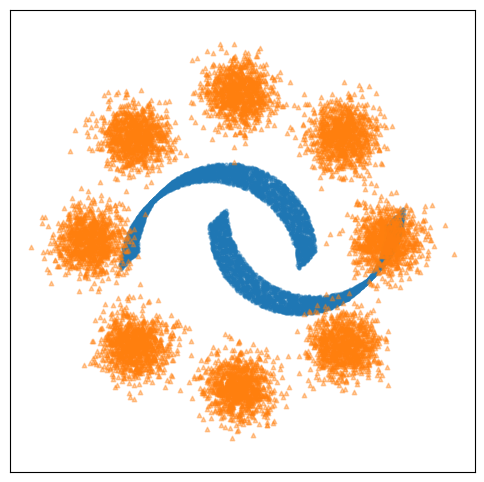

(8000, 8000)

In [27]:
config = Configs(target='TwoMoons', 
                 source='Ngaussians', 
                 num_points=8000, 
                 num_gaussians=8,
                 vocab_size=8,
                 dim_discrete=0
                 )

data = DataCoupling(config)

_, ax = plt.subplots(1, 1, figsize=(6, 6)) 
data.target.display( s=4, ax=ax, cmap='tab10', marker='o', alpha=0.4)
data.source.display(s=10, ax=ax, cmap='tab10', marker='^', alpha=0.4)
plt.show()

len(data.target), len(data.source)

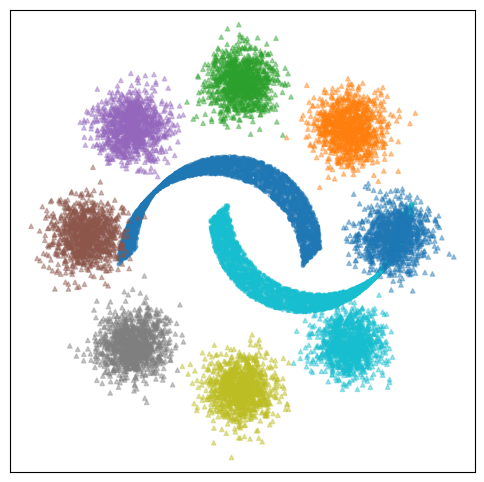

(8000, 8000)

In [28]:
config = Configs(target='TwoMoons', 
                 source='Ngaussians', 
                 num_points=8000, 
                 num_gaussians=8,
                 vocab_size=8,
                 dim_discrete=1
                 )

data = DataCoupling(config)

_, ax = plt.subplots(1, 1, figsize=(6, 6)) 
data.target.display( s=4, ax=ax, cmap='tab10', marker='o', alpha=0.4)
data.source.display(s=10, ax=ax, cmap='tab10', marker='^', alpha=0.4)
plt.show()

len(data.target), len(data.source)

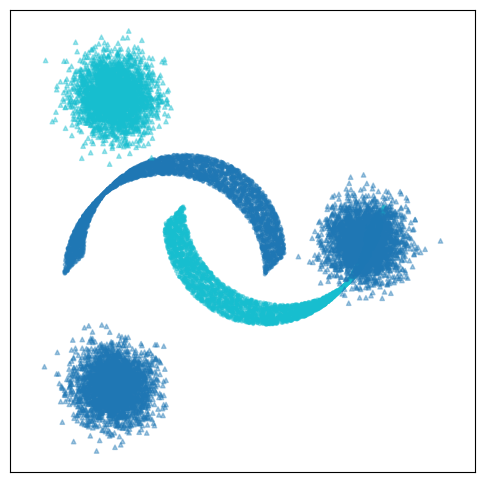

(8000, 7998)

In [32]:
config = Configs(target='TwoMoons', 
                 source='Ngaussians', 
                 num_points=8000, 
                 num_gaussians=3,
                 vocab_size=2,
                 dim_discrete=1
                 )

data = DataCoupling(config)

_, ax = plt.subplots(1, 1, figsize=(6, 6)) 
data.target.display( s=4, ax=ax, cmap='tab10', marker='o', alpha=0.4)
data.source.display(s=10, ax=ax, cmap='tab10', marker='^', alpha=0.4)
plt.show()

len(data.target), len(data.source)